In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Read in words

words = open(file='../data/names.txt',mode='r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
len(words)

32033

In [6]:
chars   = sorted(set(''.join(words)))
stoi    = {s:i+1 for i,s in enumerate(chars)} # string to integer
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()} # integer to string
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
# Building the dataset
block_size = 3

X, Y = [], [] # x is input, y is label (i.e. pred)
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
    
        print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y) 

emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


We are going to create a neural net similar to the one documented in Bengio et al. 2003 MLP language model paper[https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf]


![neural](./img/neural-net.png)

Below we have created 32 examples with 3 inputs (i.e. 3 chars inputted to each example) into the model 

In [8]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

Lets create embeddings in a two dimensional space. We have 27 characters, each of which will have a 2d embedding

In [9]:
C = torch.randn((27,2)) # 27 characters each which have 2 dimensional space
C

tensor([[-1.2390, -0.3829],
        [-0.7375,  2.3232],
        [ 2.0541, -0.2431],
        [ 0.4572,  0.6199],
        [-1.3032,  2.0805],
        [-0.6624,  1.0359],
        [ 0.5053, -1.1615],
        [-1.3936, -0.0835],
        [-0.1454,  0.3790],
        [ 0.2019, -0.4656],
        [-0.1572, -0.9834],
        [-0.9728, -0.8930],
        [ 1.3629, -1.8232],
        [-1.1577,  0.7091],
        [ 0.4809,  1.4603],
        [-0.8150,  0.5297],
        [ 1.1393, -1.0622],
        [ 1.3302, -0.2331],
        [-0.1615, -1.4612],
        [ 1.3653,  0.6976],
        [-0.5930, -0.0704],
        [-0.3041, -0.5467],
        [-0.8799, -0.3690],
        [-0.0424,  0.4078],
        [-0.8259, -0.4262],
        [-0.3623,  0.1643],
        [ 1.1954,  1.3525]])

The below gets the embedding value for 5th index

In [10]:
C[5]

tensor([-0.6624,  1.0359])

We can also feed in multidimension tensors. In our case, we can feed in C[X] where X = torch.Size([32, 3]) 32 examples with 3 inputs for each

Creates our embedding

In [11]:
# embed all our values
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

Now lets create layer 1

![layer](./img/neural-net-layer-1.png)

looking at the image above and the fact that torch.Size([32, 3, 2]), we require 6 weights as 3*2 (i.e. 3 inputs with in 2 dimensional embedding)

Number of neurons is a variable which we can decide on, we choose 100 

For biases, we'll also need 100 to match the neurons

In [12]:
# Create weights for next layer 
W1 = torch.rand((6, 100))
b1 = torch.rand(100)

Next we want to muiltiply our weights and add bias but we cant as emb is a torch.Size([32, 3, 2])

we can use pytorch view to do this. We concatenate across dimension 1 which combines the 3 different inputs (i.e. blocks of chars)

In [13]:
# -1 just lets pytorch figure out the value required
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # concat our original emb to a 32 * 6 so we can multiply weight and add bias
h

tensor([[-0.9874, -0.9196, -0.9942,  ..., -0.9475, -0.9442, -0.9931],
        [-0.7125,  0.0161, -0.9042,  ..., -0.6510, -0.7985, -0.9338],
        [-0.5415,  0.4576, -0.9293,  ..., -0.2443,  0.0136, -0.9190],
        ...,
        [ 0.9211, -0.2328,  0.1572,  ...,  0.8940,  0.8514,  0.7750],
        [ 0.6316,  0.9218,  0.1955,  ..., -0.5748,  0.5575, -0.1888],
        [ 0.9863,  0.9649,  0.8140,  ...,  0.9269,  0.8538,  0.9430]])

In [14]:
h.shape

torch.Size([32, 100])

Now let's create the final layer
![layer](./img/neural-net-layer-2.png)

In [15]:
W2 = torch.randn(100, 27) # input is 100 neurons, and output is 27 as 27 possible characters
b2 = torch.randn(27)

In [16]:
logits = h @ W2 + b2

In [17]:
logits.shape

torch.Size([32, 27])

Exponentiate logits and normalize

In [18]:
counts = logits.exp() # make sure all values are positive and amplify differences

In [19]:
prob = counts / counts.sum(1, keepdims=True) # normalise to get prob distribution, sum along second dimension

In [20]:
prob.shape

torch.Size([32, 27])

Now we need to introduce our prediction sequence Y

We want to identify the probability from each row of prob, we want to pluck out the probability assigned to the correct character

In [21]:
prob[torch.arange(32), Y] # for each row, pick out the probability of the correct Y value

tensor([5.9326e-12, 9.5565e-13, 4.4418e-11, 5.3651e-05, 9.8488e-01, 1.0019e-07,
        3.0443e-08, 1.9751e-03, 6.3265e-08, 2.2657e-09, 8.2542e-07, 8.8791e-01,
        1.1187e-07, 1.1144e-07, 5.2041e-06, 9.9482e-01, 2.1614e-09, 5.3337e-10,
        5.0337e-04, 5.2182e-20, 1.5248e-10, 3.4162e-16, 9.5047e-13, 2.1067e-05,
        9.8023e-01, 1.5964e-12, 4.6135e-08, 5.6742e-02, 1.3901e-15, 6.0681e-08,
        1.3570e-09, 9.9875e-01])

In [22]:
"""
Now let's get the negative log likelihood loss
"""

loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(16.5566)

# ------------ now made respectable :) ---------------

# Broken down into training, dev, and test set

In [23]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) # 80% 
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [24]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [25]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [26]:
sum(p.nelement() for p in parameters) # number of parameters in total

10281

In [27]:
for p in parameters:
    p.requires_grad = True

Another way to calculate loss is to use pytorch cross entropy

In [28]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponent
lrs = 10**lre # learning rates
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [29]:
lri, lossi, stepi = [], [], [] # learning rates used and losses

In [30]:
# Forward pass
for i in range(30000):

    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    emb = C[Xtr[ix]] # index into X to only grab ix rows (32, 3, 2)
    # -1 just lets pytorch figure out the value required
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # concat our original emb to a 32 * 6 so we can multiply weight and add bias
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass 
    for p in parameters:
        p.grad = None # reset weights    
    loss.backward()
    # Update
    # lr = lrs[i] # vary the learning rate, start off with small learning rate and go to large learning rate
    lr = 0.05
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())

plot the learning rates and loss exponent to see what the optimal learning rate is. below we can deduce .1 us a good learning rate as exponent pf -1 is .1

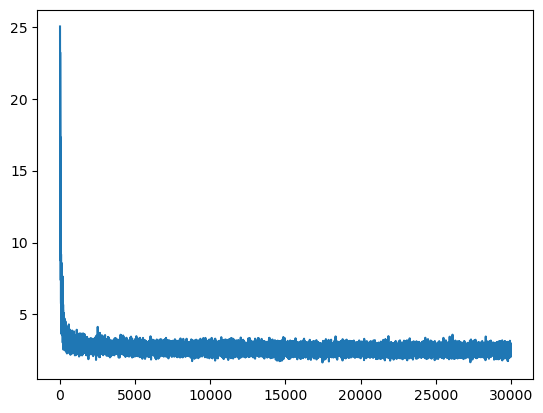

In [31]:

plt.plot(stepi, lossi)

Get loss for all of Xdev and all of Ydev, above we are calculating loss of minibatches

In [32]:
# Training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # concat our original emb to a 32 * 6 so we can multiply weight and add bias
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4955, grad_fn=<NllLossBackward0>)

In [33]:
# evaluate dev loss
# Evaluate training loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # concat our original emb to a 32 * 6 so we can multiply weight and add bias
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4952, grad_fn=<NllLossBackward0>)

In [34]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

p

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

Now lets split our data into training, dev, and test 80%, 10%, 10% respective

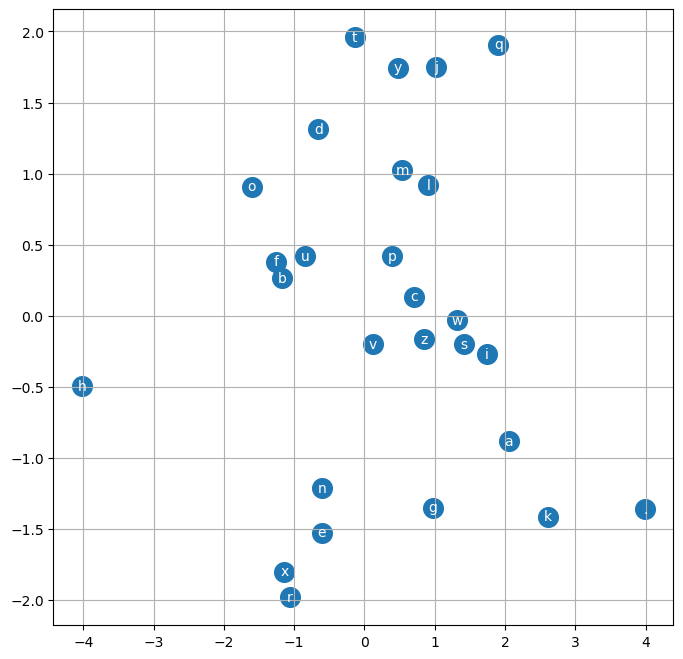

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
# Note, this wont work when we scale up embedding dimensions
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

# ------------ Scaling up embeddings ---------------
We will use the same code as above

In [ ]:
# build the dataset
block_size = 4 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) # 80% 
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182691, 4]) torch.Size([182691])
torch.Size([22793, 4]) torch.Size([22793])
torch.Size([22662, 4]) torch.Size([22662])


In [ ]:
Xtr.shape, Ytr.shape

(torch.Size([182691, 4]), torch.Size([182691]))

In [ ]:
vocab_size = len(itos)
n_embd = 40
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden ), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

38707

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponent
lrs = 10**lre # learning rates
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [35]:
lri, lossi, stepi = [], [], [] # learning rates used and losses

In [ ]:
emb = C[Xtr]
emb.shape

torch.Size([182691, 4, 40])

In [ ]:
max_steps = 250000
# Forward pass
for i in range(max_steps):

    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (block_size * n_embd, ))

    emb = C[Xtr[ix]] # index into X to only grab ix rows 
    # -1 just lets pytorch figure out the value required
    h = torch.tanh(emb.view(-1, block_size * n_embd) @ W1 + b1) # concat our original emb so we can multiply weight and add bias
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass 
    for p in parameters:
        p.grad = None # reset weights    
    loss.backward()
    # Update
    # lr = lrs[i] # vary the learning rate, start off with small learning rate and go to large learning rate
    lr = 0.1 if lr < 100000 else (0.01 if lr < 200000 else 0.005)
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
     # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 250000: 30.2250
  10000/ 250000: 2.6593
  20000/ 250000: 2.2309
  30000/ 250000: 2.0897
  40000/ 250000: 2.0886
  50000/ 250000: 2.2690
  60000/ 250000: 2.0579
  70000/ 250000: 2.1704
  80000/ 250000: 2.0307
  90000/ 250000: 1.9620
 100000/ 250000: 2.1330
 110000/ 250000: 2.1541
 120000/ 250000: 1.9534
 130000/ 250000: 1.9027
 140000/ 250000: 1.8519
 150000/ 250000: 2.0820
 160000/ 250000: 1.8505
 170000/ 250000: 2.2889
 180000/ 250000: 1.9825
 190000/ 250000: 2.0752
 200000/ 250000: 1.9565
 210000/ 250000: 2.1254
 220000/ 250000: 1.9895
 230000/ 250000: 2.1992
 240000/ 250000: 1.9318


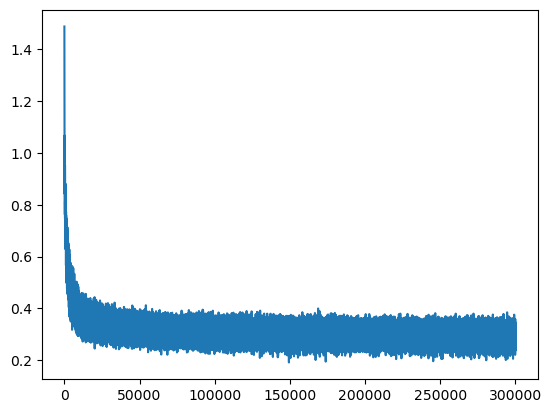

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9623043537139893
val 2.1438703536987305


# Task: improve the model
- things we can do 
- Increase embedding size
- increase middle hidden layer
- Optimize training (learning rate etc)
- batch size

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
aalyn.
riha.
miri.
tatyah.
cassie.
rahnen.
amery.
chareen.
nelmara.
chaiif.
kaleigh.
hama.
kinder.
juliani.
raina.
bilorat.
raisaryia.
jaxen.
durah.


# <----- PART 3 ---->

In [101]:
vocab_size = len(itos)
n_embd = 40
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden ), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # scale down hidden layer weights
b2 = torch.randn(vocab_size, generator=g) * 0 # initialize bias that is 0
parameters = [C, W1, b1, W2, b2]

In [102]:
sum(p.nelement() for p in parameters) # number of parameters in total

30707

In [103]:
for p in parameters:
    p.requires_grad = True

In [104]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponent
lrs = 10**lre # learning rates
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [105]:
emb = C[Xtr]
emb.shape

torch.Size([182625, 3, 40])

In [106]:
max_steps = 250000
# Forward pass
for i in range(max_steps):

    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (block_size * n_embd, ))

    emb = C[Xtr[ix]] # index into X to only grab ix rows 
    # -1 just lets pytorch figure out the value required
    h = torch.tanh(emb.view(-1, block_size * n_embd) @ W1 + b1) # concat our original emb so we can multiply weight and add bias
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass 
    for p in parameters:
        p.grad = None # reset weights    
    loss.backward()
    # Update
    # lr = lrs[i] # vary the learning rate, start off with small learning rate and go to large learning rate
    lr = 0.1 if lr < 100000 else (0.01 if lr < 200000 else 0.005)
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
     # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 250000: 3.2975
  10000/ 250000: 2.1424
  20000/ 250000: 2.3215
  30000/ 250000: 1.9324
  40000/ 250000: 2.0940


In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [36]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

caraav.
amu.
havi.
kimra.
rev.
cannan.
san.
rahnen.
dan.
ant.
kaqei.
nelania.
chaiiv.
kane.
gpu.
lu.
poin.
qannn.
sroilan.
van.


In [69]:
logits = torch.rand(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs[2]

tensor(0.0359)